In [1]:
import sys
!{sys.executable} -m pip install PyAthena

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
# 連結Athena
from pyathena import connect
import pandas as pd
conn = connect(s3_staging_dir='s3://aws-athena-query-results-331110211119-ap-southeast-1/',
               region_name='ap-southeast-1')

In [3]:
from datetime import datetime
import time
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
!pip install xgboost
!pip install lightgbm

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import numpy as np
import sklearn.metrics
from pylab import rcParams
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.1 MB/s eta 0:00:0000:0100:01
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.8 MB/s eta 0:00:0000:01


In [6]:
# Loading data

In [7]:
str_base_total = '''SELECT *
FROM "vn_life_table"."alvin_claim_test_total_base"
WHERE pol_check_year = '2021' or pol_check_year = '2022' '''

In [8]:
df = pd.read_sql(str_base_total, conn)

/tmp/ipykernel_10171/1833690272.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(str_base_total, conn)


In [10]:
df.head()

,month_as_customer_rider,customer_age,pol_holder_num,pay_amt_int,pol_check_year,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,min_date,max_pol_check_date,poL_check_month,min_date_rider,pol_check_date,gender,customer_number,regist_date,create_date,education,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,income_flg
0,10,28.0,2bcbc62a871a28e,2100000.0,2021,0,1,0,1,0,1,0,0,0,2,1,1,1,2022-03-22,2021-05-24,05,2022-03-22,2021-05-24,2,2bcbc62a871a28e,1992-07-01,2021-05-19,University,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,normal,1_income_0_10M
1,13,36.0,a5d93df7893d136,1950000.0,2021,0,0,0,1,1,0,0,0,0,1,1,0,1,2022-11-21,2021-11-05,11,2022-11-21,2021-11-05,1,a5d93df7893d136,1985-02-01,2021-09-24,Specialist,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,normal,1_income_0_10M
2,21,28.0,5bb4032f7e2a857,12425000.0,2022,0,1,1,1,0,0,1,1,2,2,1,0,1,2022-03-14,2022-12-01,12,2022-03-14,2021-12-03,1,5bb4032f7e2a857,1994-06-01,2020-05-20,University,1,1,0,0,15000000.0,1,0,0,0,0,0,1,0,1,early,2_income_10M_20M
3,5,36.0,4df7c6a460b43c1,1500000.0,2022,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-11-06,2022-05-18,05,2022-11-06,2022-05-18,2,4df7c6a460b43c1,1985-06-01,2022-05-13,high school,1,1,0,0,8000000.0,1,0,0,0,0,0,1,0,1,normal,1_income_0_10M
4,4,55.0,cfc01e6b70cb1fe,750000.0,2022,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-11-25,2022-08-18,08,2022-11-25,2022-08-18,2,cfc01e6b70cb1fe,1966-10-01,2022-07-17,Secondary school,1,1,0,0,8000000.0,1,0,0,0,0,0,0,0,1,normal,1_income_0_10M


In [11]:
df.dtypes

month_as_customer_rider            int64
customer_age                     float64
pol_holder_num                    object
pay_amt_int                      float64
pol_check_year                    object
rider_spouse                       int64
rider_other                        int64
rider_self                         int64
rider_children                     int64
pay_freq_type_monthly              int64
pay_freq_type_quarterly            int64
pay_freq_type_half_year            int64
pay_freq_type_yearly               int64
early_sum                          int64
normal_sum                         int64
apply_claim_type_disease_sum       int64
apply_claim_type_accident_sum      int64
disease_chk_hosp_m_ind             int64
min_date                          object
max_pol_check_date                object
poL_check_month                   object
min_date_rider                    object
pol_check_date                    object
gender                            object
customer_number 

In [13]:
df.columns

Index(['month_as_customer_rider', 'customer_age', 'pol_holder_num',
       'pay_amt_int', 'pol_check_year', 'rider_spouse', 'rider_other',
       'rider_self', 'rider_children', 'pay_freq_type_monthly',
       'pay_freq_type_quarterly', 'pay_freq_type_half_year',
       'pay_freq_type_yearly', 'early_sum', 'normal_sum',
       'apply_claim_type_disease_sum', 'apply_claim_type_accident_sum',
       'disease_chk_hosp_m_ind', 'min_date', 'max_pol_check_date',
       'poL_check_month', 'min_date_rider', 'pol_check_date', 'gender',
       'customer_number', 'regist_date', 'create_date', 'education',
       'address_household', 'address_correspondence', 'address_company',
       'address_legal_person', 'income_max', 'marriage_married',
       'marriage_unmarried', 'marriage_divorce', 'marriage_widowed',
       'marriage_other', 'job_Trade_affairs', 'job_F_B_Services',
       'job_Education', 'job_other', 'early_normal_claim', 'income_flg'],
      dtype='object')

In [14]:
df.shape

(7387, 44)

In [15]:
df.nunique()

month_as_customer_rider           108
customer_age                       49
pol_holder_num                   7387
pay_amt_int                       595
pol_check_year                      2
rider_spouse                        2
rider_other                         2
rider_self                          2
rider_children                      2
pay_freq_type_monthly               2
pay_freq_type_quarterly             2
pay_freq_type_half_year             2
pay_freq_type_yearly                2
early_sum                           7
normal_sum                          8
apply_claim_type_disease_sum        2
apply_claim_type_accident_sum       2
disease_chk_hosp_m_ind              2
min_date                          815
max_pol_check_date                606
poL_check_month                    12
min_date_rider                    815
pol_check_date                    833
gender                              3
customer_number                  7387
regist_date                       506
create_date 

Text(0.5, 1.0, 'Fraud Reported')

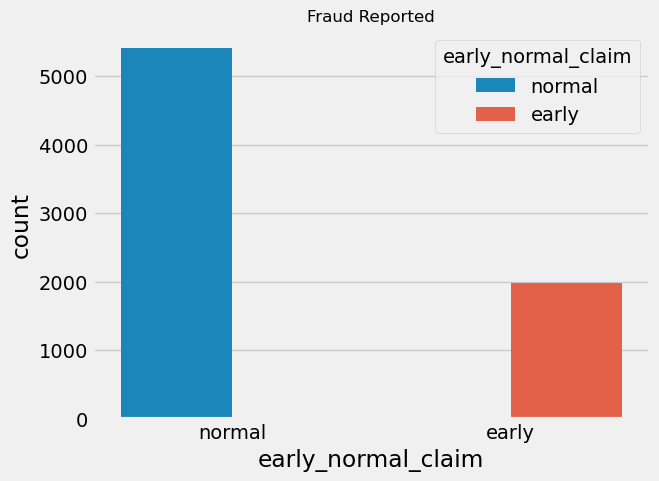

In [16]:
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='early_normal_claim', data=df, hue='early_normal_claim')
plt.title('Fraud Reported', fontsize=12)

In [17]:
df['early_normal_claim'].value_counts() # Count number of frauds vs non-frauds

normal    5409
early     1978
Name: early_normal_claim, dtype: int64

In [19]:
# DISTRIBUTION

In [18]:
df['education'].value_counts()

high school         2938
University          2070
Secondary school     893
Specialist           851
other                407
Primary school        97
Advanced              78
Master-PhD            53
Name: education, dtype: int64

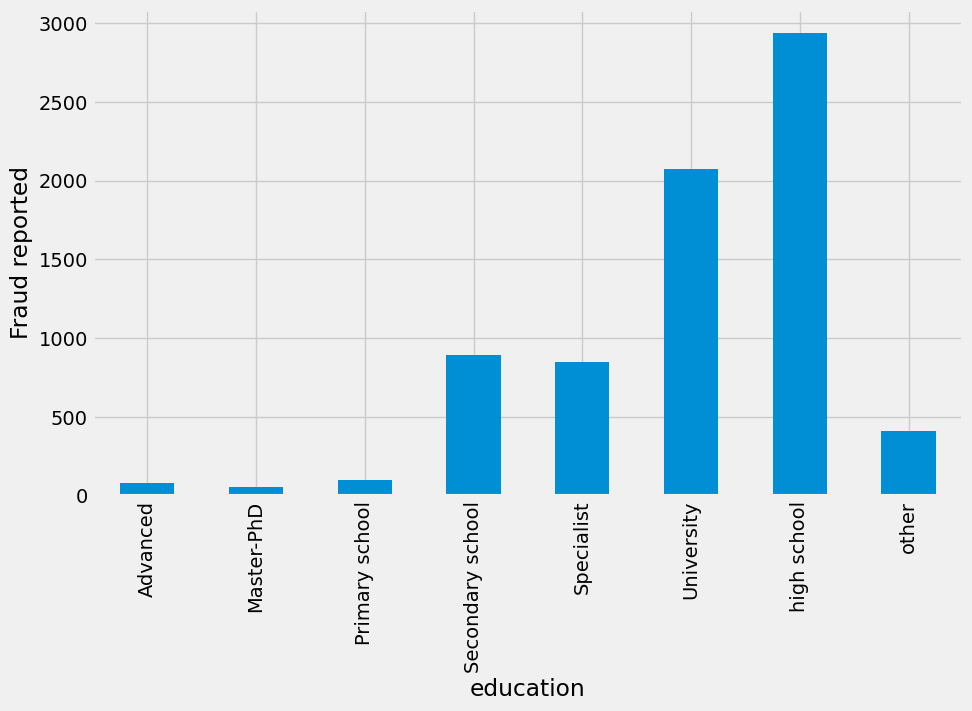

In [20]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,6))
ax = df.groupby('education').early_normal_claim.count().plot.bar(ylim=0)
ax.set_ylabel('Fraud reported')
plt.show()

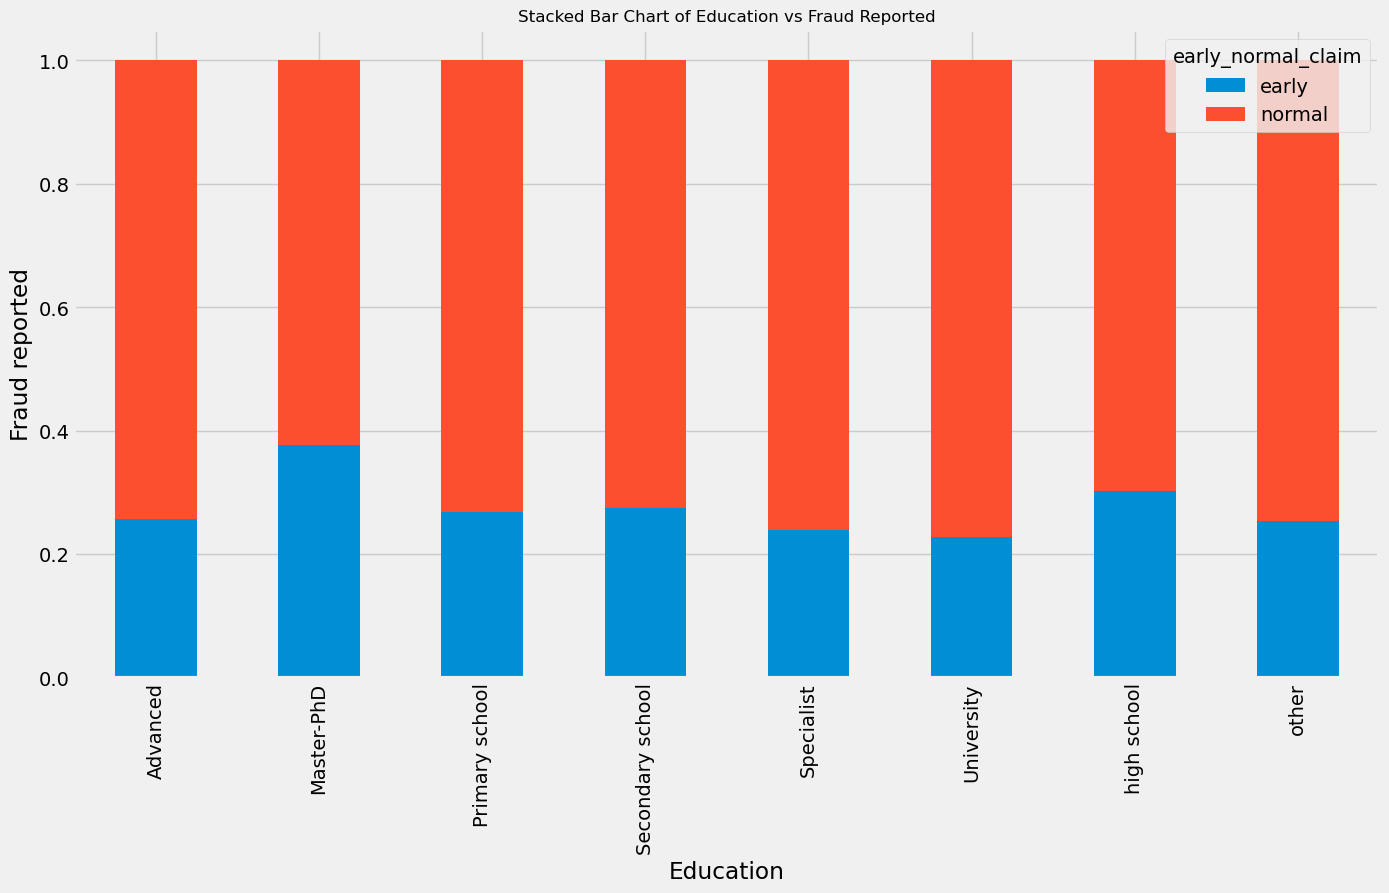

In [21]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(df.education, df.early_normal_claim)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Fraud Reported', fontsize=12)
plt.xlabel('Education')
plt.ylabel('Fraud reported')
plt.show()

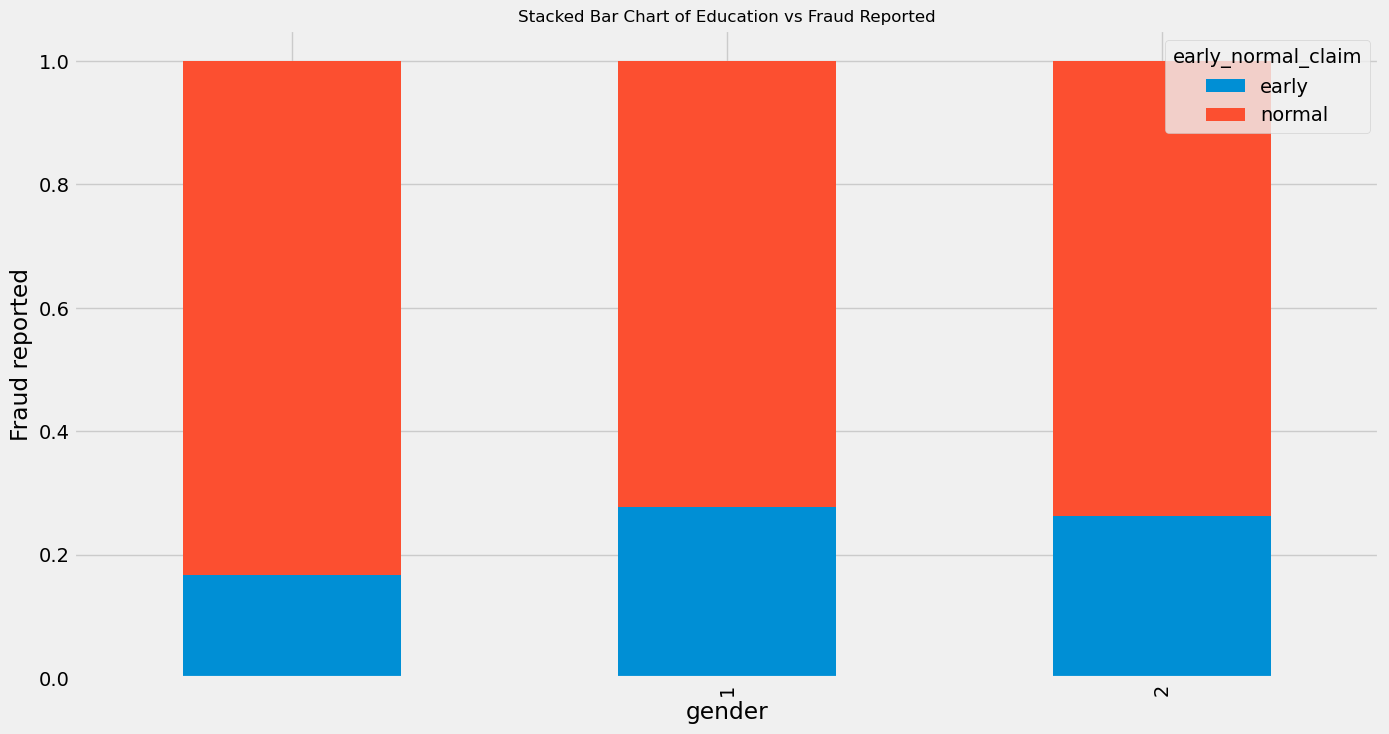

In [22]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(df.gender, df.early_normal_claim)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Fraud Reported', fontsize=12)
plt.xlabel('gender')
plt.ylabel('Fraud reported')
plt.show()

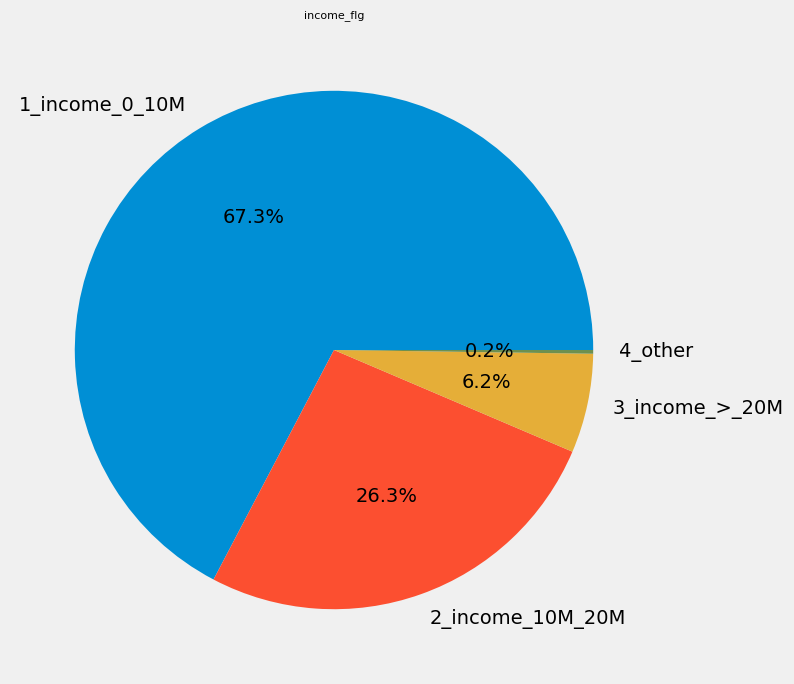

In [30]:
#bins = [0, 18, 30, 40]
labels = ['1_income_0_10M','2_income_10M_20M', '3_income_>_20M', '4_other']
#df['income_max'] = pd.cut(df.income_max, bins, labels = labels,include_lowest = True)

income_flg = df.income_flg.value_counts().to_frame()
income_flg = income_flg.rename(columns={'index':'income_flg', 'income_flg':'counts'})
income_flg.reset_index()

labels = income_flg.index.sort_values().tolist()
sizes = income_flg.counts.sort_index().tolist()
explode = (0, 0.1, 0, 0)

fig1, ax1 = plt.subplots()
#ax1.pie(sizes, labels=labels, colors =sns.color_palette(palette='YlOrBr'), startangle= -30)
#ax1.axis('equal')
#plt.legend(title='', loc='upper right', labels= labels)
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.set_title('income_flg', fontsize = 8)

plt.show()

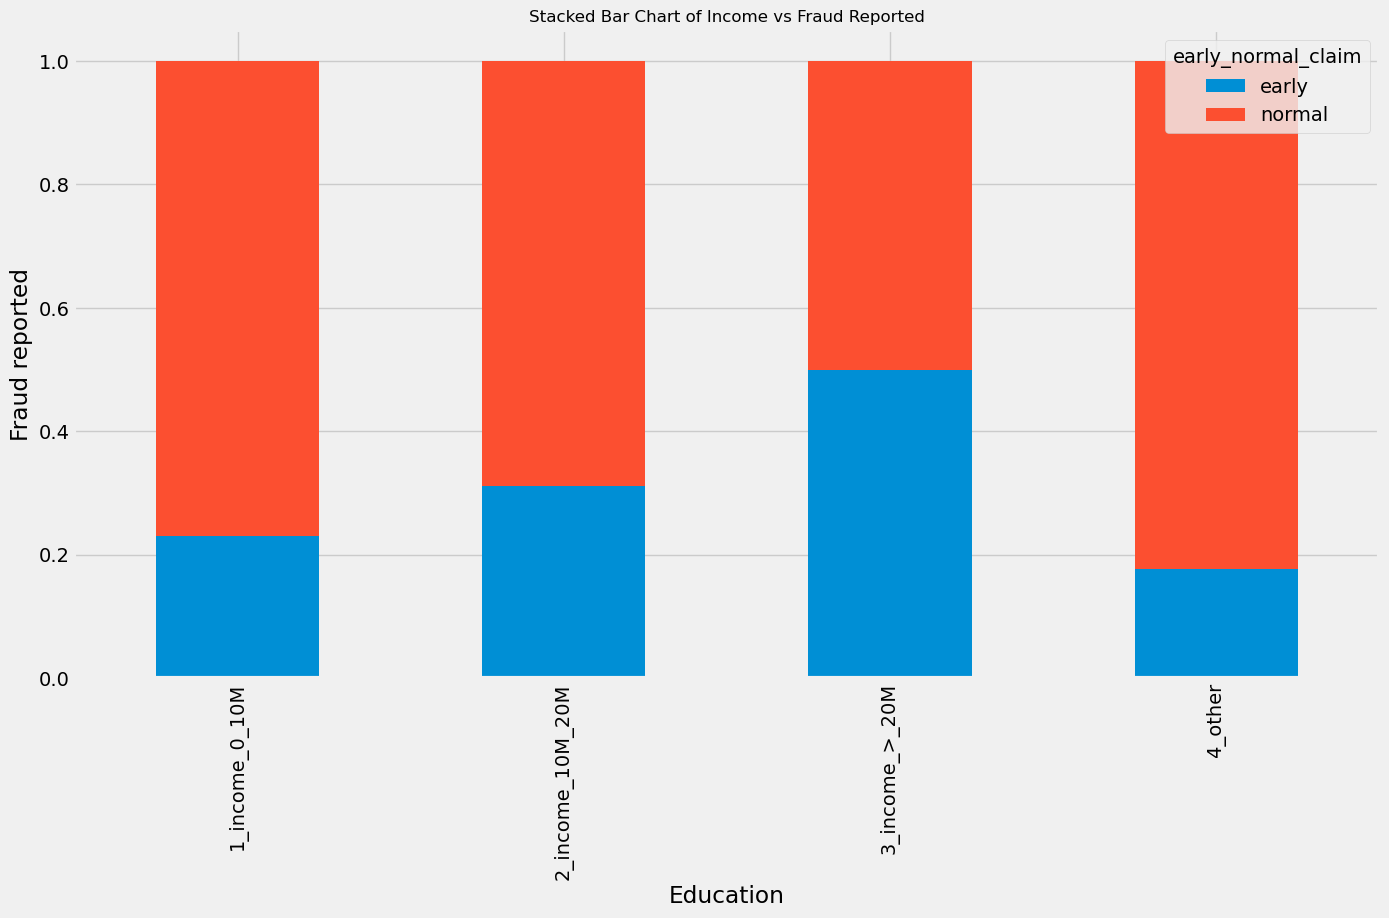

In [25]:
plt.rcParams['figure.figsize'] = [15, 8]
ax= plt.style.use('fivethirtyeight')
table=pd.crosstab(df.income_flg, df.early_normal_claim)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Income vs Fraud Reported', fontsize=12)
plt.xlabel('Education')
plt.ylabel('Fraud reported')
plt.show()

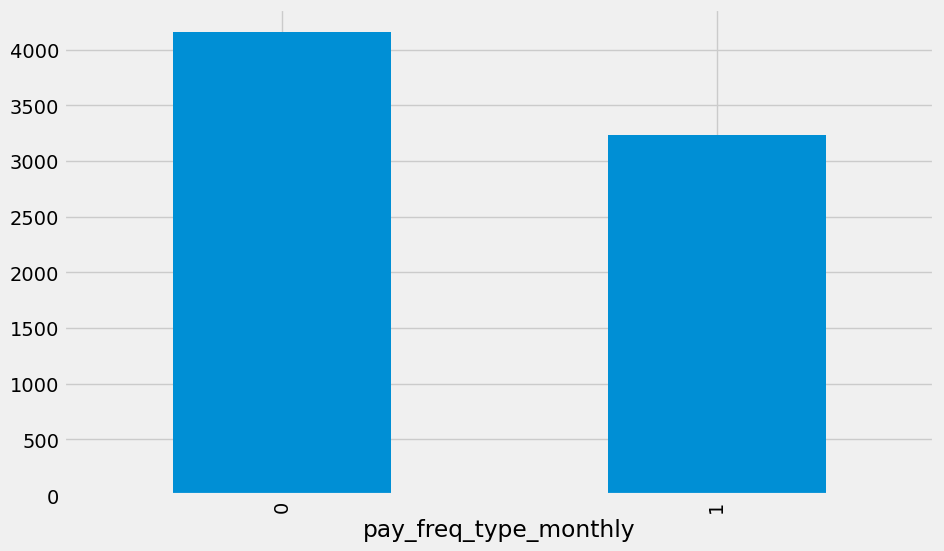

In [20]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,6))
ax = df.groupby('pay_freq_type_monthly').early_normal_claim.count().plot.bar(ylim=0)
ax.set_ylabel('')
plt.show()

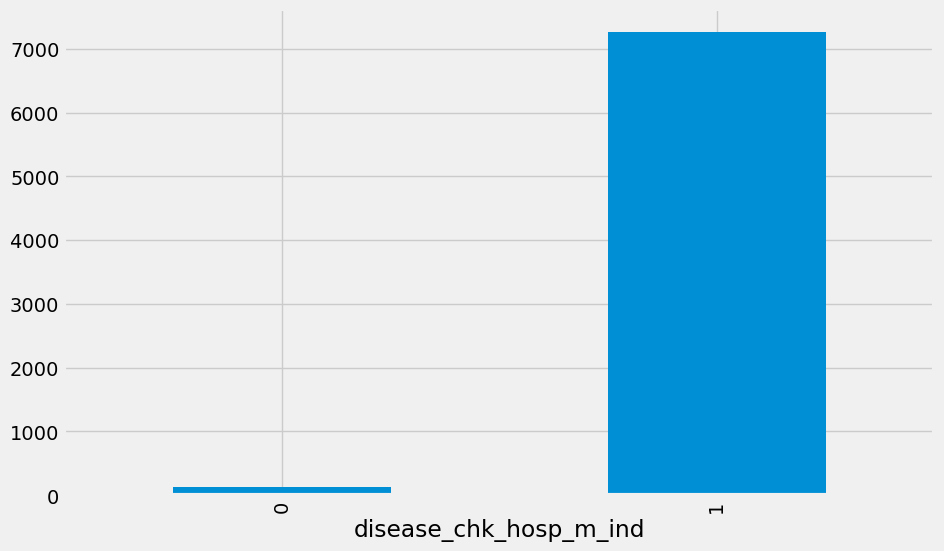

In [32]:
plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,6))
ax = df.groupby('disease_chk_hosp_m_ind').early_normal_claim.count().plot.bar(ylim=0)
ax.set_ylabel('')
plt.show()

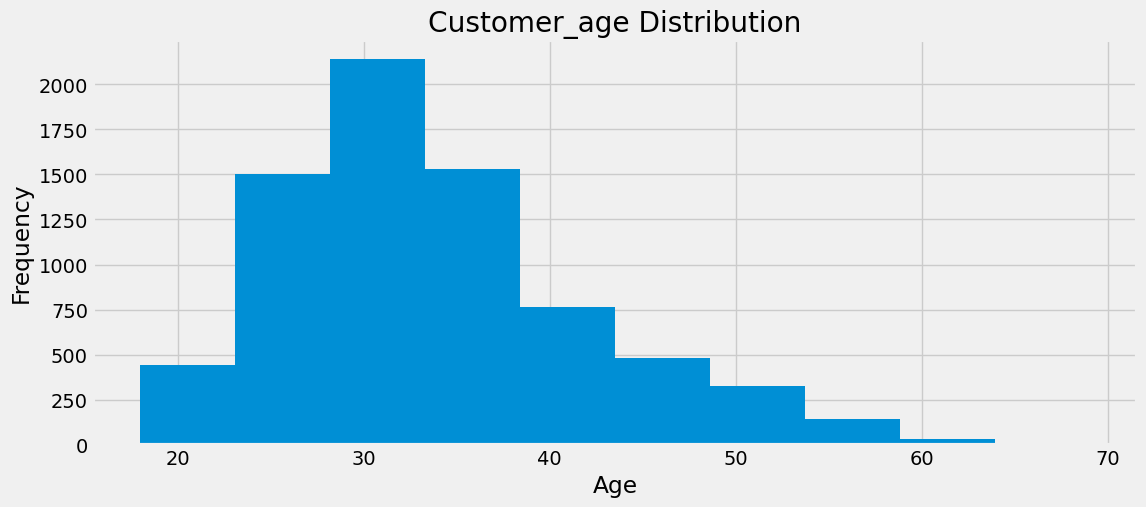

In [102]:

df.customer_age.plot(kind='hist')
# Set the title and labels
plt.title('Customer_age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [ ]:
## DATA processing

In [35]:
df['early_normal_claim'].replace(to_replace='early', value=1, inplace=True)
df['early_normal_claim'].replace(to_replace='normal',  value=0, inplace=True)

df.head()

,month_as_customer_rider,customer_age,pol_holder_num,pay_amt_int,pol_check_year,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,min_date,max_pol_check_date,poL_check_month,min_date_rider,pol_check_date,gender,customer_number,regist_date,create_date,education,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,income_flg
0,10,28.0,2bcbc62a871a28e,2100000.0,2021,0,1,0,1,0,1,0,0,0,2,1,1,1,2022-03-22,2021-05-24,05,2022-03-22,2021-05-24,2,2bcbc62a871a28e,1992-07-01,2021-05-19,University,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M
1,13,36.0,a5d93df7893d136,1950000.0,2021,0,0,0,1,1,0,0,0,0,1,1,0,1,2022-11-21,2021-11-05,11,2022-11-21,2021-11-05,1,a5d93df7893d136,1985-02-01,2021-09-24,Specialist,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0,1_income_0_10M
2,21,28.0,5bb4032f7e2a857,12425000.0,2022,0,1,1,1,0,0,1,1,2,2,1,0,1,2022-03-14,2022-12-01,12,2022-03-14,2021-12-03,1,5bb4032f7e2a857,1994-06-01,2020-05-20,University,1,1,0,0,15000000.0,1,0,0,0,0,0,1,0,1,1,2_income_10M_20M
3,5,36.0,4df7c6a460b43c1,1500000.0,2022,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-11-06,2022-05-18,05,2022-11-06,2022-05-18,2,4df7c6a460b43c1,1985-06-01,2022-05-13,high school,1,1,0,0,8000000.0,1,0,0,0,0,0,1,0,1,0,1_income_0_10M
4,4,55.0,cfc01e6b70cb1fe,750000.0,2022,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-11-25,2022-08-18,08,2022-11-25,2022-08-18,2,cfc01e6b70cb1fe,1966-10-01,2022-07-17,Secondary school,1,1,0,0,8000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M


In [36]:
df.describe()

,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim
count,7387.000000,7381.000000,7.387000e+03,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.0,7387.0,7387.000000,7387.0,7.374000e+03,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000
mean,9.964126,33.934155,4.804905e+06,0.020035,0.873291,0.038852,0.136050,0.437661,0.210640,0.157168,0.237173,0.310816,0.919182,0.893597,0.135102,0.982808,1.0,1.0,0.135914,0.0,1.260484e+07,0.827806,0.155679,0.046974,0.012048,0.001624,0.151618,0.279951,0.070123,0.814268,0.267768
std,11.855477,8.125006,3.316258e+07,0.140130,0.332669,0.193255,0.342865,0.496132,0.407791,0.363984,0.425378,0.586698,0.689635,0.308374,0.341856,0.129996,0.0,0.0,0.342721,0.0,1.770620e+07,0.377575,0.362575,0.211598,0.109108,0.040275,0.358674,0.449005,0.255372,0.388916,0.442826
min,-38.000000,18.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,28.000000,6.000000e+05,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.0,0.000000,0.0,7.000000e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,7.000000,32.000000,1.500000e+06,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.0,0.000000,0.0,1.000000e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,13.000000,38.000000,2.900000e+06,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.0,1.0,0.000000,0.0,1.500000e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,165.000000,69.000000,1.950000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,15.000000,11.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,0.0,8.000000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [37]:
df.describe(include='all')

,month_as_customer_rider,customer_age,pol_holder_num,pay_amt_int,pol_check_year,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,min_date,max_pol_check_date,poL_check_month,min_date_rider,pol_check_date,gender,customer_number,regist_date,create_date,education,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,income_flg
count,7387.000000,7381.000000,7387,7.387000e+03,7387,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387,7387,7387,7387,7387,7387,7387,7387,7387,7387,7387.0,7387.0,7387.000000,7387.0,7.374000e+03,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387.000000,7387
unique,NaN,NaN,7387,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,815,606,12,815,833,3,7387,506,1222,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,NaN,NaN,2bcbc62a871a28e,NaN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-07-19,2021-07-13,07,2022-07-19,2021-07-13,2,2bcbc62a871a28e,1991-10-01,2021-07-12,high school,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1_income_0_10M
freq,NaN,NaN,1,NaN,4549,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,85,1009,36,78,5091,1,62,114,2938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4972
mean,9.964126,33.934155,NaN,4.804905e+06,NaN,0.020035,0.873291,0.038852,0.136050,0.437661,0.210640,0.157168,0.237173,0.310816,0.919182,0.893597,0.135102,0.982808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.135914,0.0,1.260484e+07,0.827806,0.155679,0.046974,0.012048,0.001624,0.151618,0.279951,0.070123,0.814268,0.267768,NaN
std,11.855477,8.125006,NaN,3.316258e+07,NaN,0.140130,0.332669,0.193255,0.342865,0.496132,0.407791,0.363984,0.425378,0.586698,0.689635,0.308374,0.341856,0.129996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.342721,0.0,1.770620e+07,0.377575,0.362575,0.211598,0.109108,0.040275,0.358674,0.449005,0.255372,0.388916,0.442826,NaN
min,-38.000000,18.000000,NaN,0.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,3.000000,28.000000,NaN,6.000000e+05,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.0,7.000000e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
50%,7.000000,32.000000,NaN,1.500000e+06,NaN,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.0,1.000000e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,NaN
75%,13.000000,38.000000,NaN,2.900000e+06,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.000000,0.0,1.500000e+07,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,NaN


In [38]:
df.select_dtypes(include=['object']).columns

Index(['pol_holder_num', 'pol_check_year', 'min_date', 'max_pol_check_date',
       'poL_check_month', 'min_date_rider', 'pol_check_date', 'gender',
       'customer_number', 'regist_date', 'create_date', 'education',
       'income_flg'],
      dtype='object')

In [39]:
# dropping unimportant columns

df = df.drop(columns = [
    'pol_holder_num', 
    'pol_check_year',
    'customer_number',
    'regist_date',
    'min_date'])

df.head(2)

,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,max_pol_check_date,poL_check_month,min_date_rider,pol_check_date,gender,create_date,education,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,income_flg
0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,2021-05-24,05,2022-03-22,2021-05-24,2,2021-05-19,University,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M
1,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,2021-11-05,11,2022-11-21,2021-11-05,1,2021-09-24,Specialist,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0,1_income_0_10M


In [40]:
nan_count = df.isna().sum()
print (nan_count)

month_as_customer_rider           0
customer_age                      6
pay_amt_int                       0
rider_spouse                      0
rider_other                       0
rider_self                        0
rider_children                    0
pay_freq_type_monthly             0
pay_freq_type_quarterly           0
pay_freq_type_half_year           0
pay_freq_type_yearly              0
early_sum                         0
normal_sum                        0
apply_claim_type_disease_sum      0
apply_claim_type_accident_sum     0
disease_chk_hosp_m_ind            0
max_pol_check_date                0
poL_check_month                   0
min_date_rider                    0
pol_check_date                    0
gender                            0
create_date                       0
education                         0
address_household                 0
address_correspondence            0
address_company                   0
address_legal_person              0
income_max                  

In [41]:
# dropping rows have NaN value
df = df.dropna()

In [42]:
nan_count = df.isna().sum()
print (nan_count)

month_as_customer_rider          0
customer_age                     0
pay_amt_int                      0
rider_spouse                     0
rider_other                      0
rider_self                       0
rider_children                   0
pay_freq_type_monthly            0
pay_freq_type_quarterly          0
pay_freq_type_half_year          0
pay_freq_type_yearly             0
early_sum                        0
normal_sum                       0
apply_claim_type_disease_sum     0
apply_claim_type_accident_sum    0
disease_chk_hosp_m_ind           0
max_pol_check_date               0
poL_check_month                  0
min_date_rider                   0
pol_check_date                   0
gender                           0
create_date                      0
education                        0
address_household                0
address_correspondence           0
address_company                  0
address_legal_person             0
income_max                       0
marriage_married    

In [43]:
df.columns

Index(['month_as_customer_rider', 'customer_age', 'pay_amt_int',
       'rider_spouse', 'rider_other', 'rider_self', 'rider_children',
       'pay_freq_type_monthly', 'pay_freq_type_quarterly',
       'pay_freq_type_half_year', 'pay_freq_type_yearly', 'early_sum',
       'normal_sum', 'apply_claim_type_disease_sum',
       'apply_claim_type_accident_sum', 'disease_chk_hosp_m_ind',
       'max_pol_check_date', 'poL_check_month', 'min_date_rider',
       'pol_check_date', 'gender', 'create_date', 'education',
       'address_household', 'address_correspondence', 'address_company',
       'address_legal_person', 'income_max', 'marriage_married',
       'marriage_unmarried', 'marriage_divorce', 'marriage_widowed',
       'marriage_other', 'job_Trade_affairs', 'job_F_B_Services',
       'job_Education', 'job_other', 'early_normal_claim', 'income_flg'],
      dtype='object')

In [44]:
df._get_numeric_data().head()  # Checking numeric columns

,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim
0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0
1,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0
2,21,28.0,12425000.0,0,1,1,1,0,0,1,1,2,2,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,1,0,1,1
3,5,36.0,1500000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,1,0,1,0
4,4,55.0,750000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,0,1,0


In [45]:
df._get_numeric_data().columns

Index(['month_as_customer_rider', 'customer_age', 'pay_amt_int',
       'rider_spouse', 'rider_other', 'rider_self', 'rider_children',
       'pay_freq_type_monthly', 'pay_freq_type_quarterly',
       'pay_freq_type_half_year', 'pay_freq_type_yearly', 'early_sum',
       'normal_sum', 'apply_claim_type_disease_sum',
       'apply_claim_type_accident_sum', 'disease_chk_hosp_m_ind',
       'address_household', 'address_correspondence', 'address_company',
       'address_legal_person', 'income_max', 'marriage_married',
       'marriage_unmarried', 'marriage_divorce', 'marriage_widowed',
       'marriage_other', 'job_Trade_affairs', 'job_F_B_Services',
       'job_Education', 'job_other', 'early_normal_claim'],
      dtype='object')

In [46]:
df.select_dtypes(include=['object']).columns  # checking categorcial columns

Index(['max_pol_check_date', 'poL_check_month', 'min_date_rider',
       'pol_check_date', 'gender', 'create_date', 'education', 'income_flg'],
      dtype='object')

In [47]:
#Applying one-hot encoding to convert all categorical variables except out target variables
dummies = pd.get_dummies(df[[
    'gender', 
    'education', 
    'income_flg'
    ]])

dummies = dummies.join(df[[ 
    "early_normal_claim"]])

dummies.head()

,gender_1,gender_2,education_Advanced,education_Master-PhD,education_Primary school,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,early_normal_claim
0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,1,0,0,0,1,0,1
3,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,0,1,0,0,0,1,0,0,0,0,1,0,0,0


In [48]:
df['gender'].value_counts()

2    5085
1    2284
Name: gender, dtype: int64

In [49]:
df

,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,max_pol_check_date,poL_check_month,min_date_rider,pol_check_date,gender,create_date,education,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,income_flg
0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,2021-05-24,05,2022-03-22,2021-05-24,2,2021-05-19,University,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M
1,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,2021-11-05,11,2022-11-21,2021-11-05,1,2021-09-24,Specialist,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0,1_income_0_10M
2,21,28.0,12425000.0,0,1,1,1,0,0,1,1,2,2,1,0,1,2022-12-01,12,2022-03-14,2021-12-03,1,2020-05-20,University,1,1,0,0,15000000.0,1,0,0,0,0,0,1,0,1,1,2_income_10M_20M
3,5,36.0,1500000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-05-18,05,2022-11-06,2022-05-18,2,2022-05-13,high school,1,1,0,0,8000000.0,1,0,0,0,0,0,1,0,1,0,1_income_0_10M
4,4,55.0,750000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-08-18,08,2022-11-25,2022-08-18,2,2022-07-17,Secondary school,1,1,0,0,8000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,9,25.0,1800000.0,0,1,0,0,0,0,0,1,1,0,1,0,1,2022-01-05,01,2022-02-17,2022-01-05,1,2021-05-12,University,1,1,0,0,15000000.0,0,1,0,0,0,0,1,0,1,1,2_income_10M_20M
7383,6,33.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,2021-11-24,11,2022-06-08,2021-11-24,1,2021-11-19,University,1,1,0,0,10000000.0,1,0,0,0,0,0,0,0,1,0,1_income_0_10M
7384,4,36.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,2022-06-02,06,2022-09-13,2022-06-02,2,2022-05-04,Specialist,1,1,0,0,15000000.0,1,0,0,0,0,0,0,0,1,0,2_income_10M_20M
7385,10,30.0,1100000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,2022-02-09,02,2022-08-25,2022-02-09,2,2021-09-26,high school,1,1,0,0,6000000.0,0,1,1,0,0,0,1,0,1,0,1_income_0_10M


In [50]:
X = dummies.iloc[:, 0:-1]  # predictor variables
y = dummies.iloc[:, -1]  # target variable

In [51]:
len(X.columns)

13

In [52]:
X.head()

,gender_1,gender_2,education_Advanced,education_Master-PhD,education_Primary school,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M
0,0,1,0,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,1,0,0,0,1,0,0
2,1,0,0,0,0,0,0,1,0,0,0,1,0
3,0,1,0,0,0,0,0,0,1,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,1,0,0


In [53]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: early_normal_claim, dtype: int64

In [54]:
#data preparation

In [55]:
X = pd.concat([X, df._get_numeric_data()], axis=1)  # joining numeric columns
X.head(2)

,gender_1,gender_2,education_Advanced,education_Master-PhD,education_Primary school,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim
0,0,1,0,0,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0


In [56]:
df['pol_check_date'] = pd.to_datetime(df['pol_check_date'])

In [57]:
X = X.join(df[[ 
    "pol_check_date"]])

In [58]:
X

,gender_1,gender_2,education_Advanced,education_Master-PhD,education_Primary school,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_divorce,marriage_widowed,marriage_other,job_Trade_affairs,job_F_B_Services,job_Education,job_other,early_normal_claim,pol_check_date
0,0,1,0,0,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,0,1,0,2021-05-24
1,1,0,0,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,1,0,0,0,0,2021-11-05
2,1,0,0,0,0,0,0,1,0,0,0,1,0,21,28.0,12425000.0,0,1,1,1,0,0,1,1,2,2,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,1,0,1,1,2021-12-03
3,0,1,0,0,0,0,0,0,1,0,1,0,0,5,36.0,1500000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,1,0,1,0,2022-05-18
4,0,1,0,0,0,1,0,0,0,0,1,0,0,4,55.0,750000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,0,1,0,2022-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,1,0,0,0,0,0,0,1,0,0,0,1,0,9,25.0,1800000.0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,15000000.0,0,1,0,0,0,0,1,0,1,1,2022-01-05
7383,1,0,0,0,0,0,0,1,0,0,1,0,0,6,33.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,0,0,0,1,0,2021-11-24
7384,0,1,0,0,0,0,1,0,0,0,0,1,0,4,36.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,0,0,1,0,2022-06-02
7385,0,1,0,0,0,0,0,0,1,0,1,0,0,10,30.0,1100000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,6000000.0,0,1,1,0,0,0,1,0,1,0,2022-02-09


/tmp/ipykernel_10171/3241570536.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_table = X.corr()


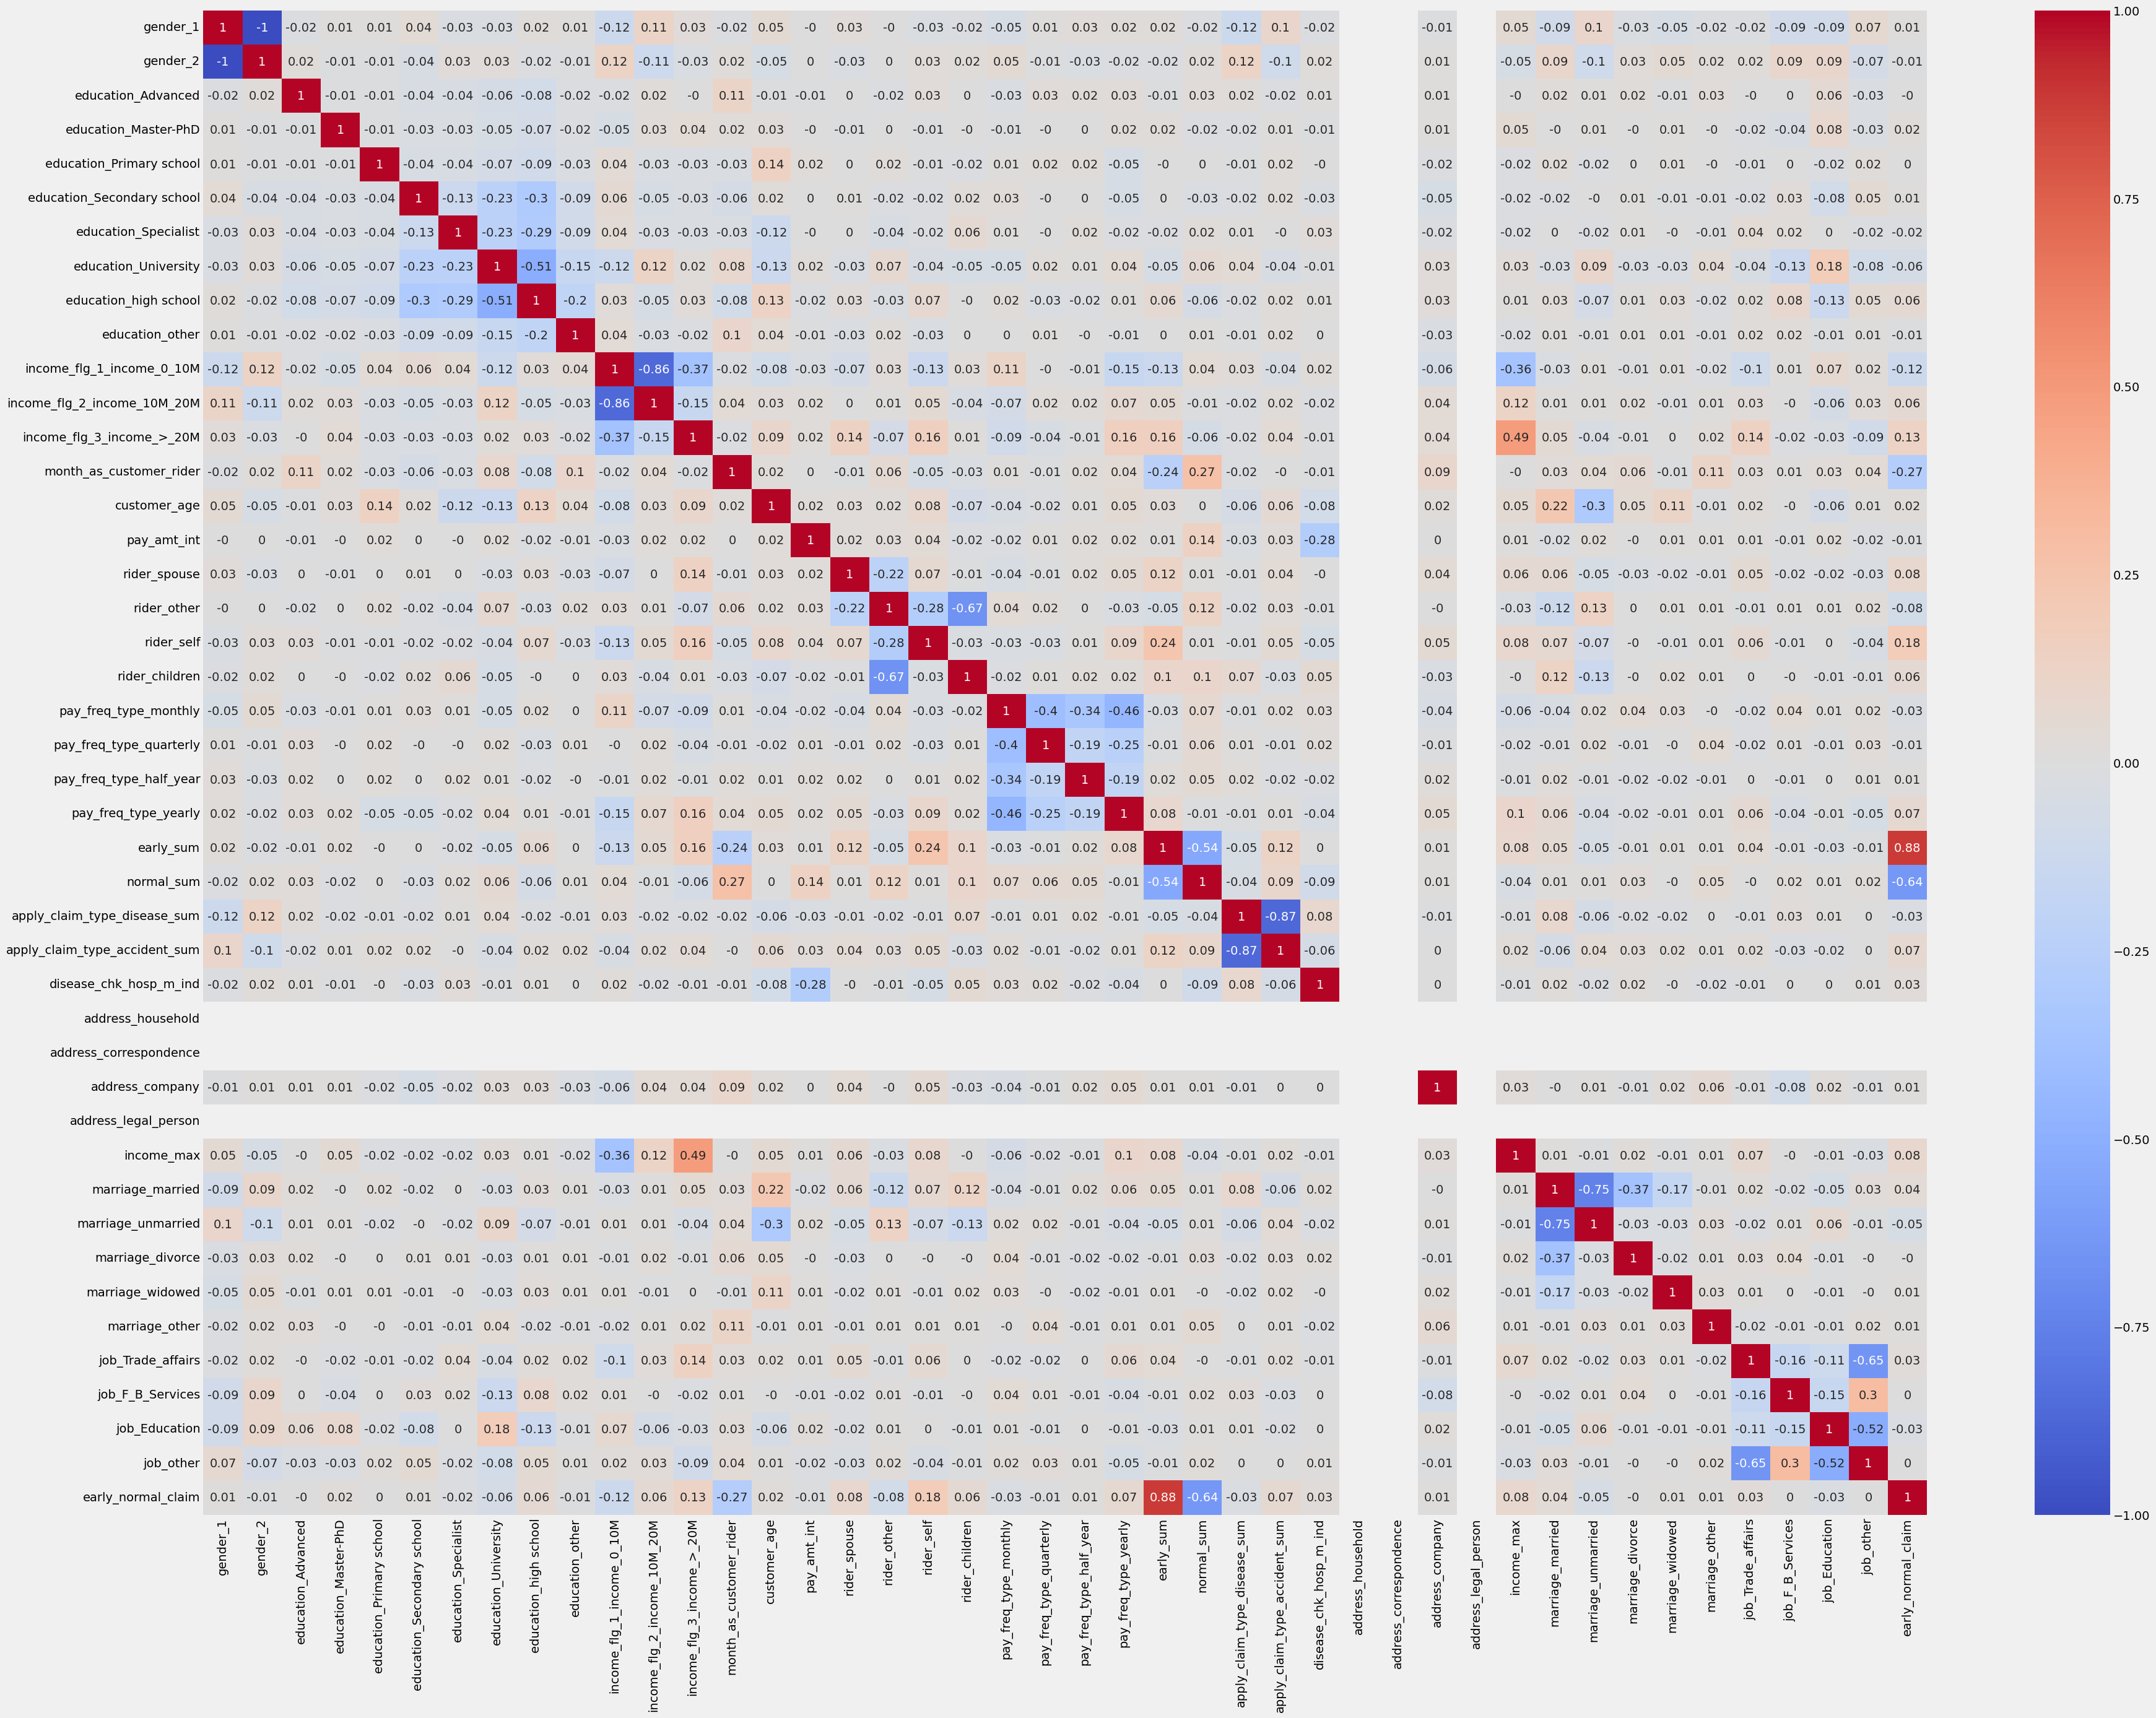

In [59]:
corr_table = X.corr()
rounded_corr_table = corr_table.round(2)

fig, ax = plt.subplots(figsize=(40, 30))
# plot the correlation table
sns.heatmap(rounded_corr_table, cmap='coolwarm', annot=True, center=0)

# show the plot
plt.show()

In [60]:
#drop columns has correlation = 0
X = X.drop(columns = [
    'education_Advanced', 
    'education_Primary school',
    'marriage_divorce',
    'job_other',
    'job_F_B_Services'])

X.head(2)

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education,early_normal_claim,pol_check_date
0,0,1,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,2021-05-24
1,1,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,1,0,0,2021-11-05


In [61]:
#X = X.drop(columns = ['early_normal_claim'])  # dropping target variable 'early_normal_claim'
#X.columns

In [62]:
X

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,early_sum,normal_sum,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education,early_normal_claim,pol_check_date
0,0,1,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,0,2,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,2021-05-24
1,1,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,1,0,0,2021-11-05
2,1,0,0,0,0,1,0,0,0,1,0,21,28.0,12425000.0,0,1,1,1,0,0,1,1,2,2,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,1,2021-12-03
3,0,1,0,0,0,0,1,0,1,0,0,5,36.0,1500000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,2022-05-18
4,0,1,0,1,0,0,0,0,1,0,0,4,55.0,750000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,2022-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,1,0,0,0,0,1,0,0,0,1,0,9,25.0,1800000.0,0,1,0,0,0,0,0,1,1,0,1,0,1,1,1,0,0,15000000.0,0,1,0,0,0,0,1,2022-01-05
7383,1,0,0,0,0,1,0,0,1,0,0,6,33.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,0,0,2021-11-24
7384,0,1,0,0,1,0,0,0,0,1,0,4,36.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,0,2022-06-02
7385,0,1,0,0,0,0,1,0,1,0,0,10,30.0,1100000.0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,1,0,0,6000000.0,0,1,0,0,0,0,0,2022-02-09


In [63]:
len(X.columns)

40

In [64]:
#check whether features's correlation > 0.6
correlated_features = set()  
correlation_matrix = X.corr()  

for i in range(len(correlation_matrix .columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.6:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
len(correlated_features)  
print (correlated_features)

{'gender_2', 'apply_claim_type_accident_sum', 'income_flg_2_income_10M_20M', 'marriage_unmarried', 'early_normal_claim', 'rider_children'}


/tmp/ipykernel_10171/2704695100.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = X.corr()


In [65]:
X = X.drop(columns = [
    'early_sum','normal_sum'])
X.head(2)

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education,early_normal_claim,pol_check_date
0,0,1,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,2021-05-24
1,1,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,10000000.0,1,0,0,0,1,0,0,2021-11-05


In [66]:
## Convert the date column to a datetime object
X['pol_check_date'] = pd.to_datetime(X['pol_check_date'])
# Determine the split date
split_date = '2022-06-30'
split_date = datetime.strptime(split_date, '%Y-%m-%d')

# Split the data into training and testing sets
train_data = X[X['pol_check_date'] <= split_date]
test_data = X[X['pol_check_date'] > split_date]

# Split the training and testing sets into X and y
X_train = train_data.drop(['pol_check_date', 'early_normal_claim'], axis=1)
y_train = train_data.iloc[:, -2]
X_test = test_data.drop(['pol_check_date', 'early_normal_claim'], axis=1)
y_test = test_data.iloc[:, -2]

In [67]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)
#print('length of X_train and X_test: ', len(X_train), len(X_test))
#print('length of y_train and y_test: ', len(y_train), len(y_test))

In [68]:
#LinearDiscrimint Analysis model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# evaluate an LDA model on the dataset using k-fold cross validation
model = LinearDiscriminantAnalysis()
kfold = KFold(n_splits=5,shuffle=True, random_state=42)
result = cross_val_score(model, X_test, y_test, cv=kfold, scoring='accuracy', error_score='raise')
print(result.mean())

0.6993963102482372


In [69]:
#Random Forest Classification

In [70]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=7)
#print('length of X_train and X_test: ', len(X_train), len(X_test))
#print('length of y_train and y_test: ', len(y_train), len(y_test))

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, cohen_kappa_score, precision_score, f1_score, confusion_matrix
from sklearn import metrics 

# Baseline Random forest based Model`
rfc = RandomForestClassifier(n_estimators=200)
rfc_f = rfc.fit(X_train, y_train)

In [72]:
def score(m, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred=m.predict(X_train)
        print('Train Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_train, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
    elif train == False:
        pred=m.predict(X_test)
        print('Test Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_test, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")

In [73]:
score(rfc_f, X_train, y_train, X_test, y_test, train=False)

Test Result:

Accuracy Score: 86.64%
Precision Score: 99.83%
Recall Score: 81.17%
F1 score: 89.54%
Confusion Matrix:
 [[300   1]
 [135 582]]


In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, classification_report, cohen_kappa_score
from sklearn import metrics 

# Baseline Random forest based Model
rfc = RandomForestClassifier(n_estimators=200)
    
kfold = KFold(n_splits=5, shuffle = True, random_state=7)
result2 = cross_val_score(rfc, X_train, y_train, cv=kfold, scoring='accuracy')
print(result2.mean())


0.9425287299355087


In [75]:
X

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education,early_normal_claim,pol_check_date
0,0,1,0,0,0,1,0,0,1,0,0,10,28.0,2100000.0,0,1,0,1,0,1,0,0,1,1,1,1,1,0,0,7000000.0,1,0,0,0,0,0,0,2021-05-24
1,1,0,0,0,1,0,0,0,1,0,0,13,36.0,1950000.0,0,0,0,1,1,0,0,0,1,0,1,1,1,0,0,10000000.0,1,0,0,0,1,0,0,2021-11-05
2,1,0,0,0,0,1,0,0,0,1,0,21,28.0,12425000.0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,1,2021-12-03
3,0,1,0,0,0,0,1,0,1,0,0,5,36.0,1500000.0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,2022-05-18
4,0,1,0,1,0,0,0,0,1,0,0,4,55.0,750000.0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,8000000.0,1,0,0,0,0,0,0,2022-08-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,1,0,0,0,0,1,0,0,0,1,0,9,25.0,1800000.0,0,1,0,0,0,0,0,1,1,0,1,1,1,0,0,15000000.0,0,1,0,0,0,0,1,2022-01-05
7383,1,0,0,0,0,1,0,0,1,0,0,6,33.0,0.0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,10000000.0,1,0,0,0,0,0,0,2021-11-24
7384,0,1,0,0,1,0,0,0,0,1,0,4,36.0,0.0,0,1,0,0,0,1,0,0,1,0,1,1,1,0,0,15000000.0,1,0,0,0,0,0,0,2022-06-02
7385,0,1,0,0,0,0,1,0,1,0,0,10,30.0,1100000.0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,6000000.0,0,1,0,0,0,0,0,2022-02-09


In [76]:
#XGBoost model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
def score(m, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred=m.predict(x_train)
        print('Train Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_train, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
    elif train == False:
        pred=m.predict(X_test)
        print('Test Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred)*100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred)*100:.2f}%")
        print(f"F1 score: {f1_score(y_test, pred)*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")
xgb = XGBClassifier()
xgb = xgb.fit(X_train, y_train)

score(xgb, X_train, y_train, X_test, y_test, train=False)

Test Result:

Accuracy Score: 86.74%
Precision Score: 99.16%
Recall Score: 81.87%
F1 score: 89.69%
Confusion Matrix:
 [[296   5]
 [130 587]]


In [77]:
X.shape

(7369, 38)

In [79]:
df_feature = pd.DataFrame({'feature':X_train.columns,'importances':rfc_f.feature_importances_})

In [80]:
df_feature.sort_values('importances', ascending=False)

,feature,importances
11,month_as_customer_rider,0.658170
13,pay_amt_int,0.078060
12,customer_age,0.057793
29,income_max,0.035064
16,rider_self,0.011206
18,pay_freq_type_monthly,0.011161
20,pay_freq_type_half_year,0.010116
21,pay_freq_type_yearly,0.009805
19,pay_freq_type_quarterly,0.009337
34,job_Trade_affairs,0.008330


In [81]:
#check if any anomalies/outliers are present in data

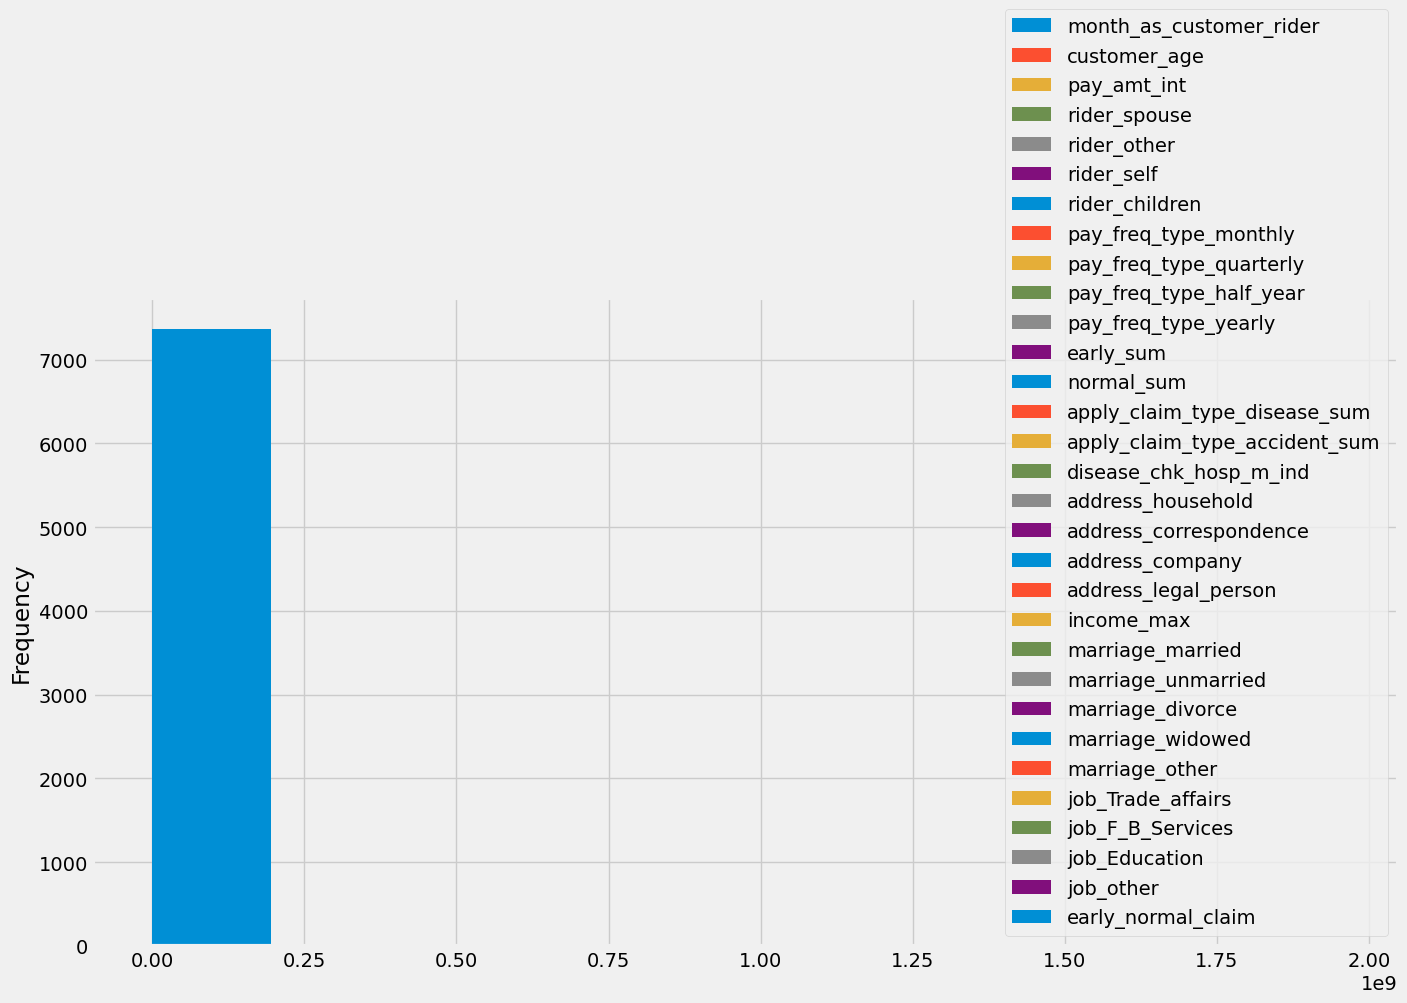

In [82]:
# Generate a Histogram plot for anomaly detection
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [15, 8]
df.plot(kind='hist')
plt.show()

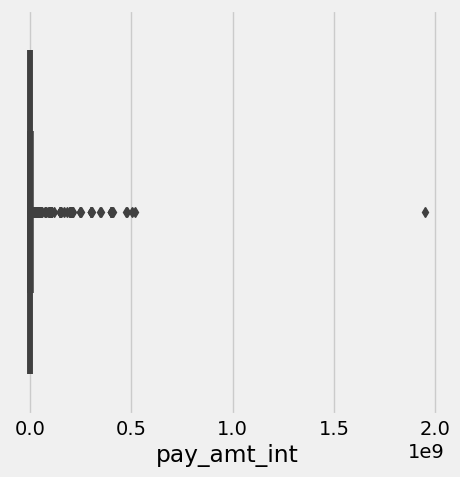

In [83]:
#check outliers for features: pay_amt_int, pay_freq_type_monthly, apply_claim_type_disease_sum, address_company, marriage_widowed, early_normal_claim
plt.rcParams['figure.figsize'] = [5, 5]
sns.boxplot(x=X.pay_amt_int)
plt.show()

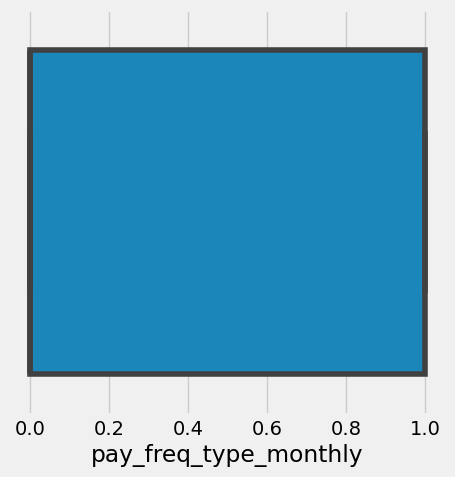

In [84]:
sns.boxplot(x=X.pay_freq_type_monthly)
plt.show()

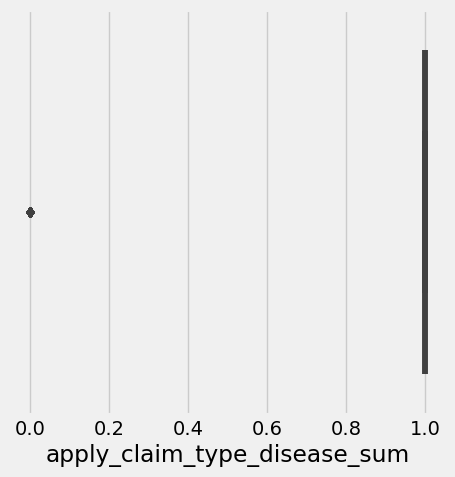

In [85]:
sns.boxplot(x=X.apply_claim_type_disease_sum)
plt.show()

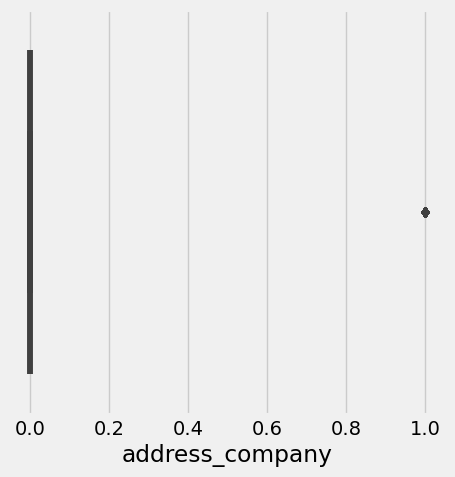

In [86]:
sns.boxplot(x=X.address_company)
plt.show()

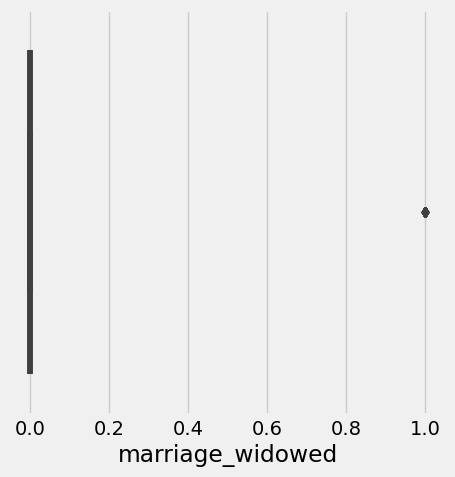

In [87]:
sns.boxplot(x=X.marriage_widowed)
plt.show()

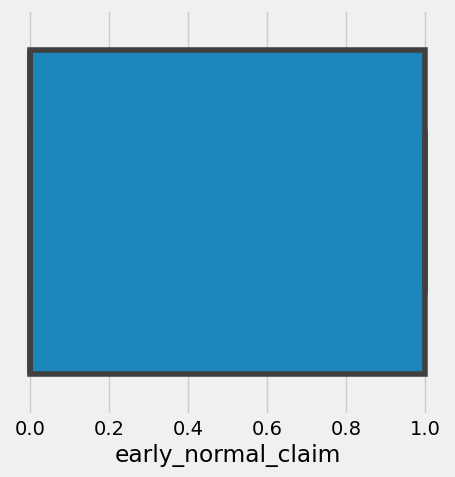

In [88]:
sns.boxplot(x=X.early_normal_claim)
plt.show()

In [89]:
#Standardizing the data and recheck the data distribution

In [91]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [93]:
X_train_scaled

array([[0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.16123098, 0.        , 0.        , ..., 0.        , 2.83358828,
        0.        ],
       [2.16123098, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        3.86581577]])

In [95]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns) # retaining columns names
X_train_scaled.head(2)

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education
0,0.000000,2.161231,0.0,0.0,0.000000,2.207284,0.0,0.0,2.193644,0.0,0.0,0.858004,3.516305,0.058796,0.0,3.292489,0.0,2.968361,0.000000,2.427372,0.0,0.0,3.261761,2.928339,7.171123,1.0,1.0,0.0,0.0,0.424500,2.61111,0.0,0.0,0.0,0.000000,0.0
1,2.161231,0.000000,0.0,0.0,3.095123,0.000000,0.0,0.0,2.193644,0.0,0.0,1.115405,4.520964,0.054597,0.0,0.000000,0.0,2.968361,2.008422,0.000000,0.0,0.0,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.606428,2.61111,0.0,0.0,0.0,2.833588,0.0


In [97]:
X_train_scaled

,gender_1,gender_2,education_Master-PhD,education_Secondary school,education_Specialist,education_University,education_high school,education_other,income_flg_1_income_0_10M,income_flg_2_income_10M_20M,income_flg_3_income_>_20M,month_as_customer_rider,customer_age,pay_amt_int,rider_spouse,rider_other,rider_self,rider_children,pay_freq_type_monthly,pay_freq_type_quarterly,pay_freq_type_half_year,pay_freq_type_yearly,apply_claim_type_disease_sum,apply_claim_type_accident_sum,disease_chk_hosp_m_ind,address_household,address_correspondence,address_company,address_legal_person,income_max,marriage_married,marriage_unmarried,marriage_widowed,marriage_other,job_Trade_affairs,job_Education
0,0.000000,2.161231,0.0,0.0,0.000000,2.207284,0.000000,0.0,2.193644,0.000000,0.0,0.858004,3.516305,0.058796,0.0,3.292489,0.000000,2.968361,0.000000,2.427372,0.000000,0.000000,3.261761,2.928339,7.171123,1.0,1.0,0.0,0.0,0.424500,2.61111,0.00000,0.0,0.0,0.000000,0.000000
1,2.161231,0.000000,0.0,0.0,3.095123,0.000000,0.000000,0.0,2.193644,0.000000,0.0,1.115405,4.520964,0.054597,0.0,0.000000,0.000000,2.968361,2.008422,0.000000,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.606428,2.61111,0.00000,0.0,0.0,2.833588,0.000000
2,2.161231,0.000000,0.0,0.0,0.000000,2.207284,0.000000,0.0,0.000000,2.314649,0.0,1.801809,3.516305,0.347879,0.0,3.292489,6.834693,2.968361,0.000000,0.000000,2.726812,2.423559,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.909642,2.61111,0.00000,0.0,0.0,0.000000,0.000000
3,0.000000,2.161231,0.0,0.0,0.000000,0.000000,2.055274,0.0,2.193644,0.000000,0.0,0.429002,4.520964,0.041997,0.0,3.292489,0.000000,0.000000,2.008422,0.000000,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.485143,2.61111,0.00000,0.0,0.0,0.000000,0.000000
4,2.161231,0.000000,0.0,0.0,0.000000,0.000000,2.055274,0.0,0.000000,2.314649,0.0,0.514803,4.520964,0.012599,0.0,3.292489,0.000000,0.000000,2.008422,0.000000,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.909642,2.61111,0.00000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6346,2.161231,0.000000,0.0,0.0,0.000000,2.207284,0.000000,0.0,0.000000,2.314649,0.0,0.772204,3.139558,0.050397,0.0,3.292489,0.000000,0.000000,0.000000,0.000000,0.000000,2.423559,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.909642,0.00000,2.71392,0.0,0.0,0.000000,0.000000
6347,2.161231,0.000000,0.0,0.0,0.000000,2.207284,0.000000,0.0,2.193644,0.000000,0.0,0.514803,4.144217,0.000000,0.0,3.292489,0.000000,0.000000,0.000000,2.427372,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.606428,2.61111,0.00000,0.0,0.0,0.000000,0.000000
6348,0.000000,2.161231,0.0,0.0,3.095123,0.000000,0.000000,0.0,0.000000,2.314649,0.0,0.343202,4.520964,0.000000,0.0,3.292489,0.000000,0.000000,0.000000,2.427372,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.909642,2.61111,0.00000,0.0,0.0,0.000000,0.000000
6349,0.000000,2.161231,0.0,0.0,0.000000,0.000000,2.055274,0.0,2.193644,0.000000,0.0,0.858004,3.767470,0.030798,0.0,3.292489,0.000000,0.000000,2.008422,0.000000,0.000000,0.000000,3.261761,0.000000,7.171123,1.0,1.0,0.0,0.0,0.363857,0.00000,2.71392,0.0,0.0,0.000000,0.000000


<AxesSubplot: ylabel='Frequency'>

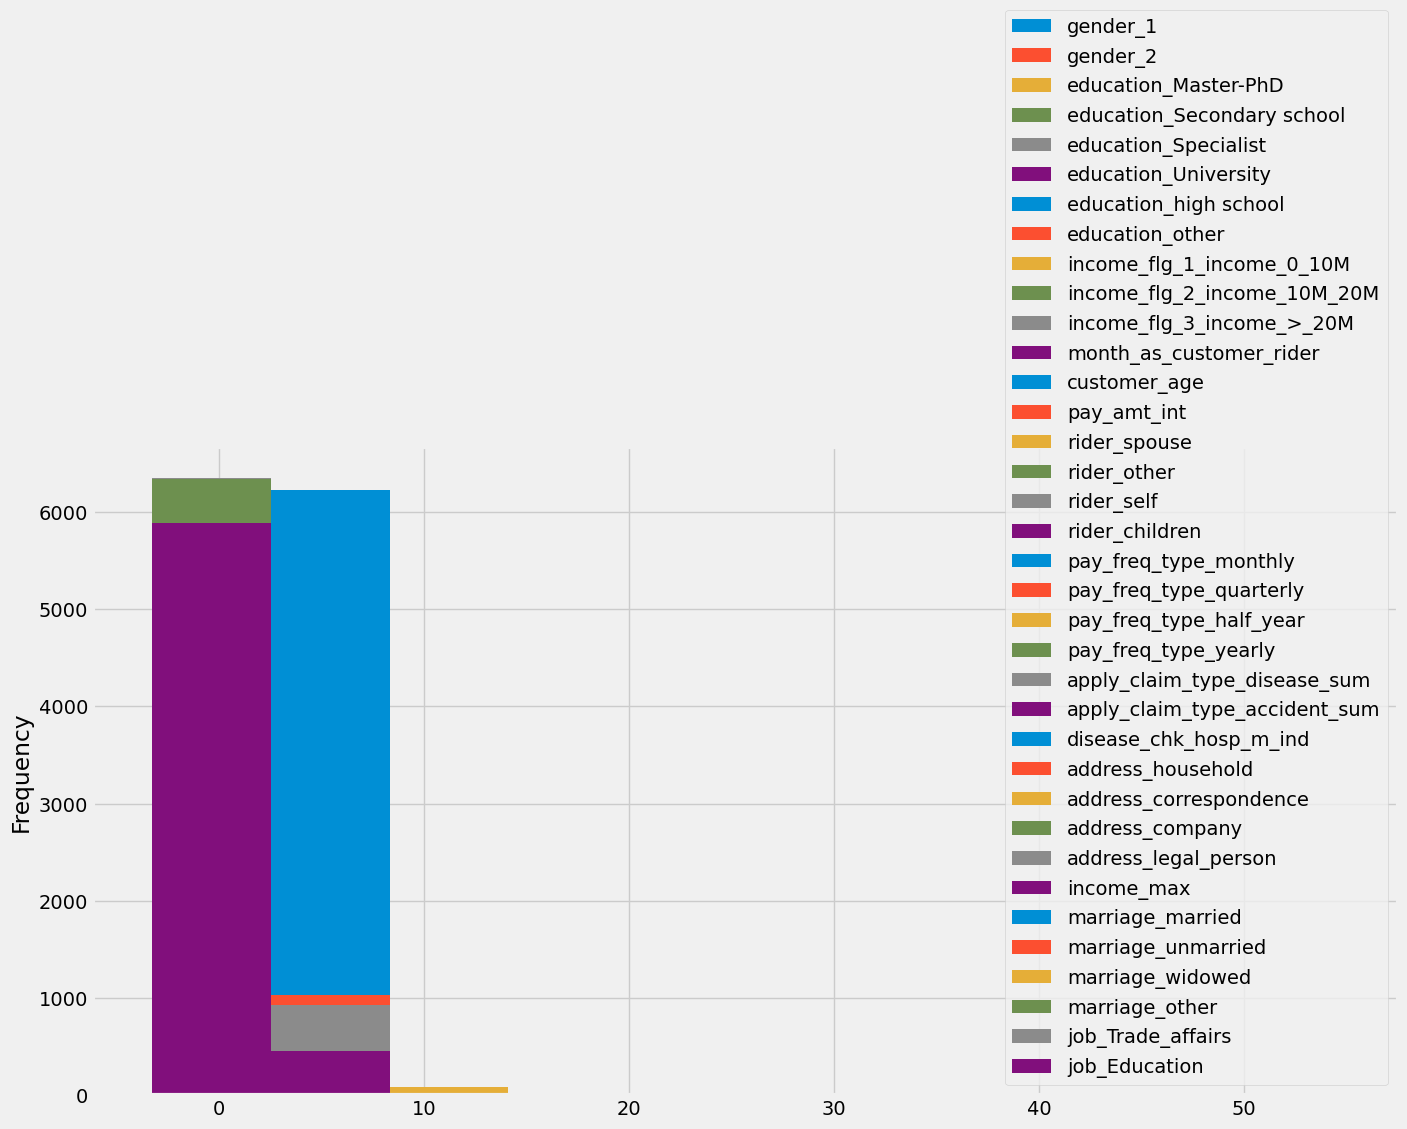

In [98]:
# Generate a Histogram plot on scaled data to check anomalies
plt.rcParams['figure.figsize'] = [15, 8]
X_train_scaled.plot(kind='hist')

In [99]:
x_train_scaled = pd.DataFrame.to_numpy(X_train_scaled) # converting to array for computational ease
x_train_scaled

array([[0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.16123098, 0.        , 0.        , ..., 0.        , 2.83358828,
        0.        ],
       [2.16123098, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.16123098, 0.        , ..., 0.        , 0.        ,
        3.86581577]])

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
LR: 0.825855 (0.011499)
XGB: 0.937332 (0.007502)
KNN: 0.808220 (0.010921)
DT: 0.895605 (0.007937)
SVM: 0.809008 (0.010566)
RF: 0.942529 (0.008712)
ADA: 0.939851 (0.008698)
LDA: 0.808220 (0.008415)
GNB: 0.772477 (0.008135)


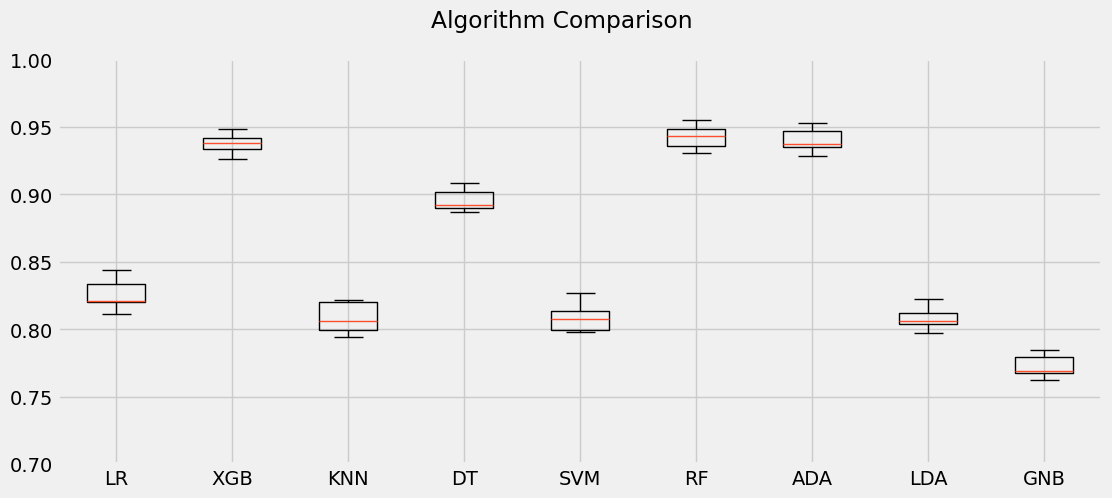

In [100]:
import sys
!{sys.executable} -m pip install xgboost
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

xgb = XGBClassifier()
logreg= LogisticRegressionCV(solver='lbfgs', cv=10)
knn = KNeighborsClassifier(5)
svcl = SVC()
adb = AdaBoostClassifier()
dt = DecisionTreeClassifier(max_depth=5)
rf = RandomForestClassifier()
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', LogisticRegressionCV(solver='lbfgs', max_iter=5000, cv=10)))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('RF', RandomForestClassifier(n_estimators=200)))
models.append(('ADA', AdaBoostClassifier(n_estimators=200)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('GNB', GaussianNB()))
              
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    
    cv_results = model_selection.cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
plt.rcParams['figure.figsize'] = [12, 5]              
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
ax.set_ylim(0.7, 1)
plt.show()

In [84]:
#we can see that the ADA (93.89%), RF (94.25%) and XGB (93.73%) have very high results

In [85]:
#VotingClassifier

In [103]:
clf1 = XGBClassifier() 
clf2 = RandomForestClassifier(n_estimators=200)
clf3 = AdaBoostClassifier(n_estimators=200)


clf = [
    ('XGB', clf1), 
    ('RF', clf2),
    ('ADA', clf3)] 
    
#create our voting classifier, inputting our models
eclf= VotingClassifier(estimators=[
    ('XGB', clf1), 
    ('RF', clf2),
    ('ADA', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], [
    'XGB Classifier', 
    'Random Forest',
    'AdaBoost Classifier']):
    
    scores = cross_val_score(clf, x_train_scaled, y_train, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))    

Accuracy: 0.94 (+/- 0.01) [XGB Classifier]
Accuracy: 0.94 (+/- 0.01) [Random Forest]
Accuracy: 0.94 (+/- 0.01) [AdaBoost Classifier]


In [104]:
from numpy import sort
from sklearn.feature_selection import SelectFromModel

# fit model on all training data
xgb = XGBClassifier()
xgb.fit(X_train_scaled, y_train)

# make predictions for test data and evaluate
xgb_pred = xgb.predict(X_test_scaled)
predictions = [round(value) for value in xgb_pred]
accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# Fit model using each importance as a threshold
thresholds = sort(xgb.feature_importances_)
for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_scaled)
    
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    # eval model
    select_X_test = selection.transform(X_test_scaled)
    xgb_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in xgb_pred]
    accuracy = accuracy_score(y_test, xgb_pred)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=36, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=36, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=36, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=36, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.000, n=36, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.015, n=31, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.016, n=30, Accuracy: 86.54%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.017, n=29, Accuracy: 86.84%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.017, n=28, Accuracy: 87.03%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.018, n=27, Accuracy: 86.54%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.018, n=26, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.018, n=25, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.019, n=24, Accuracy: 86.84%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.019, n=23, Accuracy: 86.94%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.019, n=22, Accuracy: 87.13%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.019, n=21, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.020, n=20, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.020, n=19, Accuracy: 86.74%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.020, n=18, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.022, n=17, Accuracy: 86.35%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.023, n=16, Accuracy: 86.35%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.023, n=15, Accuracy: 86.15%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.024, n=14, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.024, n=13, Accuracy: 86.84%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.025, n=12, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.026, n=11, Accuracy: 86.35%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.027, n=10, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.027, n=9, Accuracy: 86.35%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.027, n=8, Accuracy: 86.74%
Thresh=0.029, n=7, Accuracy: 86.84%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.030, n=6, Accuracy: 86.64%
Thresh=0.030, n=5, Accuracy: 86.64%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.035, n=4, Accuracy: 86.54%
Thresh=0.038, n=3, Accuracy: 86.44%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Thresh=0.056, n=2, Accuracy: 86.44%
Thresh=0.278, n=1, Accuracy: 86.35%


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

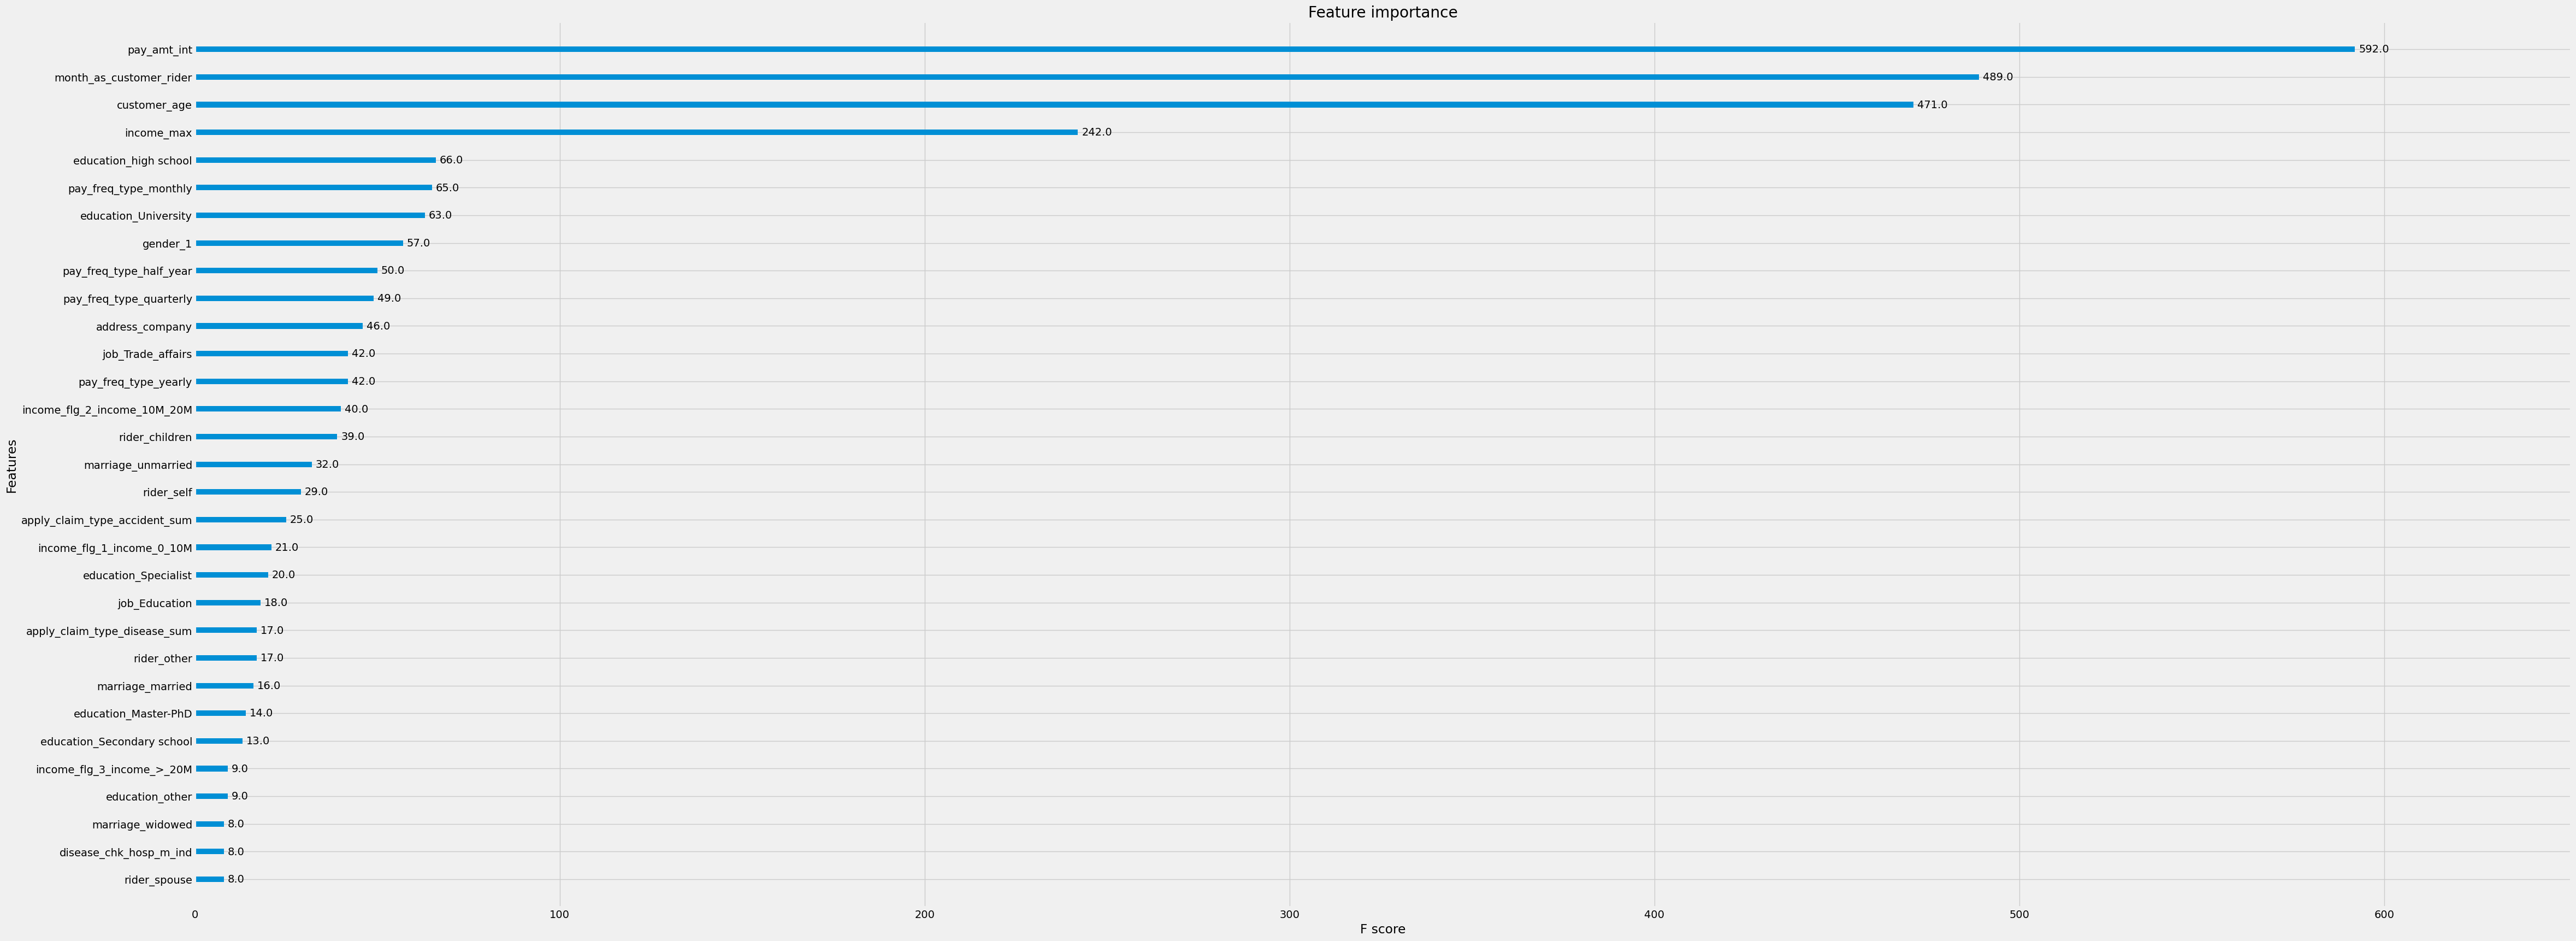

In [105]:
from xgboost import plot_importance
x = XGBClassifier()
x.fit(X_train, y_train) # fitting the model again on dataframe to identify the feature names

plt.rcParams['figure.figsize'] = [50, 20]
# plot feature importance
plot_importance(x)

In [106]:
from pprint import pprint
# Check parameters used 
print('Parameters currently in use:\n')
pprint(x.get_params())

Parameters currently in use:

{'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'objective': 'binary:logistic',
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'use_label_encoder': None,
 'validate_parameters': None,
 'verbosity': None}


In [107]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot
plt.rcParams['figure.figsize'] = [10, 6]

# grid search
max_depth = range(1, 11, 2)
print(max_depth)

param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train_scaled, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


# plot
pyplot.errorbar(max_depth, means, yerr=stds)
pyplot.title("XGBoost max_depth vs Log Loss")
pyplot.xlabel('max_depth')
pyplot.ylabel('Log Loss')

range(1, 11, 2)
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -0.184460 using {'max_depth': 1}
-0.184460 (0.013484) with: {'max_depth': 1}
-0.193060 (0.016909) with: {'max_depth': 3}
-0.212672 (0.023965) with: {'max_depth': 5}
-0.236391 (0.030536) with: {'max_depth': 7}
-0.254900 (0.035925) with: {'max_depth': 9}


Text(0, 0.5, 'Log Loss')